In [2]:
import pandas as pd
#import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
import datetime

# Add all datasets, Preprocess, Save Proccessed Data Set

In [3]:
r_dir = r'../raw_data/'
c_dir = r'../cleaned_data/'

In [ ]:
yellow_12_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-12.csv')

In [ ]:
yellow_11_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-11.csv')

In [ ]:
yellow_10_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-10.csv')

In [ ]:
yellow_9_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-09.csv')

In [13]:
yellow_8_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-08.csv')

In [5]:
yellow_7_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-07.csv')

In [ ]:
yellow_12_2018.head()

In [6]:
taxi_zone = pd.read_csv(r_dir+'taxi_zones.csv')
weather = pd.read_csv(r_dir+'nyc.csv')

In [7]:
weather_c = weather[['date_time','totalSnow_cm','precipMM','tempC']]

In [ ]:
weather_c.head()

In [8]:
# classify weather as bad by defining totalSnow_cm > 2 cm which is moderate to heavy snow and precipMM > 2.6 which is
# moderate to heavy rain
Badweather = weather_c.loc[(weather_c['totalSnow_cm']>2) |(weather_c['precipMM']>1.5)]
# extract badweather date
Badweather_date = [datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in Badweather['date_time']]

In [9]:
# 
def month_preprocess(df_o):
    df = df_o.copy()
    ind = df['trip_distance'] > 0
    df = df[ind]
    # convert to datetime object
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
    df['DOW'] = df['tpep_pickup_datetime'].dt.weekday
    df['HOD'] = df['tpep_pickup_datetime'].dt.hour
    df['DOM'] = df['tpep_pickup_datetime'].dt.day
    # keep only hour information
    df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].apply(lambda x: x.replace(minute=0,second=0))
    # Define essential columns
    essential = ['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','PULocationID','DOLocationID','DOW','HOD','DOM']
    df = df[essential]
    return df

In [ ]:
yellow_12_2018_c = yellow_12_2018.copy()
# exclude unusual ride
# trip distance > 0 
ind = yellow_12_2018_c['trip_distance'] > 0
yellow_12_2018_c = yellow_12_2018_c[ind]
# convert to datetime object
yellow_12_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_12_2018['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_12_2018_c['tpep_dropoff_datetime'] = pd.to_datetime(yellow_12_2018['tpep_dropoff_datetime'],format ='%Y-%m-%d %H:%M:%S')


In [ ]:
# create time features
yellow_12_2018_c['DOW'] = yellow_12_2018_c['tpep_pickup_datetime'].dt.weekday
yellow_12_2018_c['HOD'] = yellow_12_2018_c['tpep_pickup_datetime'].dt.hour
yellow_12_2018_c['DOM'] = yellow_12_2018_c['tpep_pickup_datetime'].dt.day
# keep only hour information
yellow_12_2018_c['tpep_pickup_datetime'] = yellow_12_2018_c['tpep_pickup_datetime'].apply(lambda x: x.replace(minute=0,second=0))

In [ ]:
# Define essential columns
essential = ['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','PULocationID','DOLocationID','DOW','HOD','DOM']

In [ ]:
yellow_12_2018_c = yellow_12_2018_c[essential]

In [ ]:
yellow_12_2018_c.head()

In [ ]:
# Save the Processed Data
yellow_12_2018_c.to_csv(c_dir+'yellow_12_2018.csv')
del yellow_12_2018

In [ ]:
yellow_11_2018_c = month_preprocess(yellow_11_2018)
yellow_11_2018_c.to_csv(c_dir+'yellow_11_2018.csv')
del yellow_11_2018

In [ ]:
yellow_10_2018_c = month_preprocess(yellow_10_2018)
yellow_10_2018_c.to_csv(c_dir+'yellow_10_2018.csv')
del yellow_10_2018

In [ ]:
yellow_9_2018_c = month_preprocess(yellow_9_2018)
yellow_9_2018_c.to_csv(c_dir+'yellow_9_2018.csv')
del yellow_9_2018

In [14]:
yellow_8_2018_c = month_preprocess(yellow_8_2018)
yellow_8_2018_c.to_csv(c_dir+'yellow_8_2018.csv')
del yellow_8_2018

In [15]:
yellow_7_2018_c = month_preprocess(yellow_7_2018)
yellow_7_2018_c.to_csv(c_dir+'yellow_7_2018.csv')
del yellow_7_2018

# Some Visual

In [ ]:
# Count and visualize the top 11 areas with most demand throughout December
# load taxi zone map
tzs=gpd.read_file(r_dir+'taxi_zones/taxi_zones.shp')
yellow_agg_12 = yellow_12_2018_c.groupby('PULocationID').count()
top11_12 = yellow_agg_12.nlargest(11,'DOLocationID')
tzs_yellow_12 = tzs.merge(top11_12, left_on = 'LocationID', right_on ='PULocationID' )

In [ ]:
f,ax = plt.subplots(1, figsize=(15,10))
ax.set_title('December Pickup top 11 Locations', fontsize=18)
tzs_yellow_12.plot(axes=ax, column = 'DOLocationID', legend = True, cmap = "Greens")

In [ ]:
# top 11 Pickup locations
tzs_yellow_12['zone']

# Feature Extraction

In [18]:
# need to convert datetime again when read
yellow_12_2018_c = pd.read_csv(c_dir+"yellow_12_2018.csv")
yellow_12_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_12_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_11_2018_c = pd.read_csv(c_dir+"yellow_11_2018.csv")
yellow_11_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_11_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_10_2018_c = pd.read_csv(c_dir+"yellow_10_2018.csv")
yellow_10_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_10_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_9_2018_c = pd.read_csv(c_dir+"yellow_9_2018.csv")
yellow_9_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_9_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_8_2018_c = pd.read_csv(c_dir+"yellow_8_2018.csv")
yellow_8_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_8_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
yellow_7_2018_c = pd.read_csv(c_dir+"yellow_7_2018.csv")
yellow_7_2018_c['tpep_pickup_datetime'] = pd.to_datetime(yellow_7_2018_c['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')


In [ ]:
yellow_9_2018_c.head()

In [20]:
# Further clean keep only rides in Each Month
yellow_12_2018_c = yellow_12_2018_c[yellow_12_2018_c.tpep_pickup_datetime.dt.month == 12]
yellow_11_2018_c = yellow_11_2018_c[yellow_11_2018_c.tpep_pickup_datetime.dt.month == 11]
yellow_10_2018_c = yellow_10_2018_c[yellow_10_2018_c.tpep_pickup_datetime.dt.month == 10]
yellow_9_2018_c = yellow_9_2018_c[yellow_9_2018_c.tpep_pickup_datetime.dt.month == 9]
yellow_8_2018_c = yellow_8_2018_c[yellow_8_2018_c.tpep_pickup_datetime.dt.month == 8]
yellow_7_2018_c = yellow_7_2018_c[yellow_7_2018_c.tpep_pickup_datetime.dt.month == 7]

In [21]:
yellow_8_2018_c.head()

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,DOW,HOD,DOM
0,0,2018-08-01,2018-08-01 01:03:22,1,238,79,2,0,1
1,2,2018-08-01,2018-08-01 00:24:40,1,138,7,2,0,1
2,3,2018-08-01,2018-08-01 00:49:10,1,231,7,2,0,1
3,4,2018-08-01,2018-08-01 00:07:32,2,79,148,2,0,1
4,5,2018-08-01,2018-08-01 00:55:23,2,114,7,2,0,1


In [22]:
yellow_7_2018_c.head()

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,DOW,HOD,DOM
0,0,2018-07-01,2018-07-01 00:28:51,1,145,145,6,0,1
1,1,2018-07-01,2018-07-01 00:30:17,1,145,145,6,0,1
2,2,2018-07-01,2018-07-01 00:08:29,2,211,144,6,0,1
3,3,2018-07-01,2018-07-01 00:36:35,1,144,142,6,0,1
4,4,2018-07-01,2018-07-01 00:50:54,1,142,141,6,0,1


In [23]:
# concatenate six months
Alldata = yellow_7_2018_c.append(yellow_8_2018_c)
Alldata = Alldata.append(yellow_9_2018_c)
Alldata = Alldata.append(yellow_10_2018_c)
Alldata = Alldata.append(yellow_11_2018_c)
Alldata = Alldata.append(yellow_12_2018_c)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [24]:
# take only time square pickup
ind = Alldata['PULocationID'] == 230
timesquare_pu = Alldata[ind]

In [25]:
# agggregate by one hour interval,groupby DOW,DOM,Hour_of_Day
# mulitlevel representation useful for aggregating computation
timesquare_pu.groupby(['tpep_pickup_datetime','DOM','DOW','HOD']).count().head()

,,,,DOLocationID,PULocationID,Unnamed: 0,Unnamed: 0.1,passenger_count,tpep_dropoff_datetime
tpep_pickup_datetime,DOM,DOW,HOD,,,,,,
2018-07-01 00:00:00,1,6,0,491,491,491,0,491,491
2018-07-01 01:00:00,1,6,1,324,324,324,0,324,324
2018-07-01 02:00:00,1,6,2,207,207,207,0,207,207
2018-07-01 03:00:00,1,6,3,146,146,146,0,146,146
2018-07-01 04:00:00,1,6,4,184,184,184,0,184,184


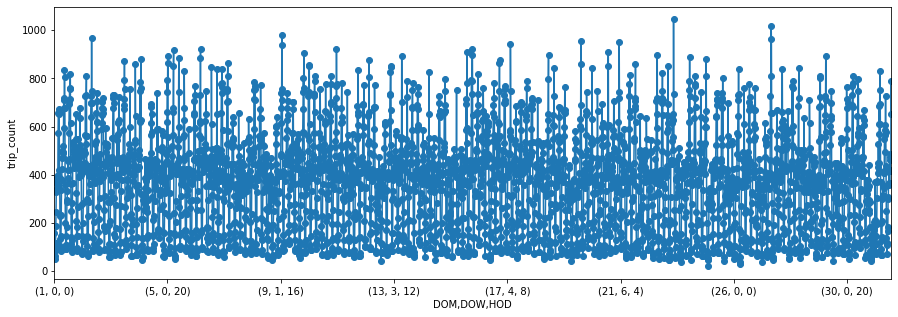

In [27]:
# pattern in whole month
hourly_count = timesquare_pu.groupby(['DOM','DOW','HOD']).count()['passenger_count']
hourly_count.rename(columns={'passenger_count':'trip_count'},inplace=True)
ax = hourly_count.plot(x='DOM', y='trip_count', kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("Hourly Pattern in a month")
ax.set_ylabel("trip_count")
plt.show()


In [28]:
# reset index  Training feature representaion
hourly_count = timesquare_pu.groupby(['tpep_pickup_datetime','DOM','DOW','HOD']).count()['passenger_count']
Timesquare_hourly_count = hourly_count.reset_index()
Timesquare_hourly_count.rename(columns={'passenger_count':'trip_count'},inplace=True)
Timesquare_hourly_count.head()

,tpep_pickup_datetime,DOM,DOW,HOD,trip_count
0,2018-07-01 00:00:00,1,6,0,491
1,2018-07-01 01:00:00,1,6,1,324
2,2018-07-01 02:00:00,1,6,2,207
3,2018-07-01 03:00:00,1,6,3,146
4,2018-07-01 04:00:00,1,6,4,184


In [29]:
# Incoporate bad weater 
Timesquare_hourly_count['bad_weather'] = np.where(Timesquare_hourly_count.tpep_pickup_datetime.isin(Badweather_date),1,0)
Timesquare_hourly_count.head()

,tpep_pickup_datetime,DOM,DOW,HOD,trip_count,bad_weather
0,2018-07-01 00:00:00,1,6,0,491,0
1,2018-07-01 01:00:00,1,6,1,324,0
2,2018-07-01 02:00:00,1,6,2,207,0
3,2018-07-01 03:00:00,1,6,3,146,0
4,2018-07-01 04:00:00,1,6,4,184,0


In [31]:
# Incoporate Holiday
import holidays
Holidays = [date for y in range(2017, 2019) for date, _ in sorted(holidays.US(years=y).items())]
# manually add new years eve
Holidays.append(datetime.date(2017, 12, 31))
Holidays.append(datetime.date(2018, 12, 31))

In [32]:
# date column created to select holidays, will be dropped
Timesquare_hourly_count['date'] = Timesquare_hourly_count.tpep_pickup_datetime.dt.date
Timesquare_hourly_count['is_holiday'] = np.where(Timesquare_hourly_count.date.isin(Holidays), 1, 0)
# next_... columns are features to be used
#Timesquare_hourly_count['nexthour_count'] = Timesquare_hourly_count.trip_count.shift(-1)
#Timesquare_hourly_count['next_isBadweather'] = Timesquare_hourly_count.bad_weather.shift(-1)

In [33]:
# Incorporate lags
maxlag = 24
lagdata=pd.DataFrame([])
for lag in range(1,maxlag+1):
        varname = 'lag' + str(lag)
        lagdata[varname] = Timesquare_hourly_count['trip_count'].iloc[maxlag-lag:len(Timesquare_hourly_count)-lag].reset_index(drop = True)
Timesquare_hourly_count_L = pd.concat([Timesquare_hourly_count.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)

In [34]:
# reorder trip_count column
temp = Timesquare_hourly_count_L['trip_count']
Timesquare_hourly_count_L = Timesquare_hourly_count_L.drop(['trip_count'],axis = 1)
Timesquare_hourly_count_L['trip_count'] = temp

In [35]:
Timesquare_hourly_count_L.head()

,tpep_pickup_datetime,DOM,DOW,HOD,bad_weather,date,is_holiday,lag1,lag2,lag3,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,2018-07-02 00:00:00,2,0,0,0,2018-07-02,0,416,401,479,...,267,146,82,97,184,146,207,324,491,273
1,2018-07-02 01:00:00,2,0,1,0,2018-07-02,0,273,416,401,...,428,267,146,82,97,184,146,207,324,147
2,2018-07-02 02:00:00,2,0,2,0,2018-07-02,0,147,273,416,...,470,428,267,146,82,97,184,146,207,83
3,2018-07-02 03:00:00,2,0,3,0,2018-07-02,0,83,147,273,...,550,470,428,267,146,82,97,184,146,76
4,2018-07-02 04:00:00,2,0,4,0,2018-07-02,0,76,83,147,...,495,550,470,428,267,146,82,97,184,73


In [36]:
Timesquare_hourly_count_L.shape

(3677, 32)

In [37]:
Timesquare_hourly_count_L.to_csv(c_dir+'TS_2018.csv')

In [7]:
Timesquare_hourly_count_L= pd.read_csv(c_dir+"TS_2018.csv")

#  Some Visual

In [8]:
# December starts on Saturday
def dailyvisual(start,end):
    ind = (Timesquare_hourly_count['DOM'] >= start) &(Timesquare_hourly_count['DOM'] <= end)
    selected_days = Timesquare_hourly_count[ind]
    # Reindex for visualization
    selected_days = selected_days.set_index(['DOW','Hour_of_Day'])
    ax = selected_days.plot( y='trip_count', kind='line', style="-o", figsize=(15,5))
    ax.set_ylabel("trip_count")
    ax.set_title('hourly pattern by DOW and Hour')
    plt.show()

In [ ]:
# First Week 12/3 - 12/9 visualize Monday to Sunday
dailyvisual(3,9)

In [ ]:
# 12/10 - 12/16
dailyvisual(10,16)

In [ ]:
#12/17-12/23
dailyvisual(17,23)

In [ ]:
#12/24-12/30
dailyvisual(24,30)

In [ ]:
#to do: add weather , add lags, create features for 5 other locations, 
# build a polynomial regression model
# model for one location --> model for several locations